Import the necessary libraries

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
import _pickle as cPickle
import copy
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from numba import jit,njit, objmode
from sys import exit
from timeit import default_timer  as timer
import decimal


Import matrix distance of a particular instance of the Symmetric Travelling Salesman Problem, extracted from a file downloaded from TSPlib. http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [25]:
####### IMPORT MATRIX DISTANCES FROM FILE

import numpy as np
import pandas as pd
import re

f= open(r'C:\Users\Jaume\Downloads\gr17.xml')

N=17
matrix=np.zeros((N,N))
i=0
j=0
for line in f:
    if line.startswith('      <edge cost="'):
        a=re.search('"(.*)"', line)
        b=re.search('>(.*)<', line)
        value=float(a[1])
        position=int(b[1])

        matrix[position,i]=value
        j=j+1
        if j%(N-1)==0 and j!=0:
            i=i+1

distances=matrix

###Optimal known order and corresponding energy of this route
sol=np.zeros((1,N,N))
orderrr=[1,4,13,7,8,6,17,14,15,3,11,10,2,5,9,12,16]
for i in range(N):
    index=orderrr[i]-1
    sol[0][i][index]=1
optimaldistance=distance(Nr, N, sol, distances, Sr)
optimalenergy=energy(Nr, lambdaa, N, sol, n, Sr)

[[  0. 633. 257.  91. 412. 150.  80. 134. 259. 505. 353. 324.  70. 211.
  268. 246. 121.]
 [633.   0. 390. 661. 227. 488. 572. 530. 555. 289. 282. 638. 567. 466.
  420. 745. 518.]
 [257. 390.   0. 228. 169. 112. 196. 154. 372. 262. 110. 437. 191.  74.
   53. 472. 142.]
 [ 91. 661. 228.   0. 383. 120.  77. 105. 175. 476. 324. 240.  27. 182.
  239. 237.  84.]
 [412. 227. 169. 383.   0. 267. 351. 309. 338. 196.  61. 421. 346. 243.
  199. 528. 297.]
 [150. 488. 112. 120. 267.   0.  63.  34. 264. 360. 208. 329.  83. 105.
  123. 364.  35.]
 [ 80. 572. 196.  77. 351.  63.   0.  29. 232. 444. 292. 297.  47. 150.
  207. 332.  29.]
 [134. 530. 154. 105. 309.  34.  29.   0. 249. 402. 250. 314.  68. 108.
  165. 349.  36.]
 [259. 555. 372. 175. 338. 264. 232. 249.   0. 495. 352.  95. 189. 326.
  383. 202. 236.]
 [505. 289. 262. 476. 196. 360. 444. 402. 495.   0. 154. 578. 439. 336.
  240. 685. 390.]
 [353. 282. 110. 324.  61. 208. 292. 250. 352. 154.   0. 435. 287. 184.
  140. 542. 238.]
 [324. 638

It is also possible to randomly generate a distance matrix:

In [311]:
### OTHERWISE GENERATE RANDOM DISTANCE MATRIX

def symmetrize_distance_matrix(v):
    d = v + np.transpose(v) - np.diag(2 * v.diagonal())
    return d

def generate_distance_matrix():
    v = np.random.ranf([N,N])
    return symmetrize_distance_matrix(v)
cities = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]
N=len(cities)
distances = np.zeros([len(cities),len(cities)])
distances=generate_distance_matrix()


@njit
def normalize_distance_matrix(N, d):
    n=np.zeros((N,N))
    dmax = np.max(d)
    dmin = np.min(d)
    for i in range(N):
        for j in range(N):
             n[i,j]=d[i,j]/dmax
    return n

[[0.         0.68276398 0.97831608 1.92803625 1.17719811]
 [0.68276398 0.         0.73029034 0.71786364 0.39022427]
 [0.97831608 0.73029034 0.         1.57397076 1.77733086]
 [1.92803625 0.71786364 1.57397076 0.         0.80970484]
 [1.17719811 0.39022427 1.77733086 0.80970484 0.        ]]
5


We normalize the distance matrix: 

In [5]:
n=normalize_distance_matrix(N,distances)
Nr=1
Sr=np.array([N])

[[0.         0.84966443 0.34496644 0.12214765 0.55302013 0.20134228
  0.10738255 0.17986577 0.34765101 0.67785235 0.4738255  0.43489933
  0.09395973 0.28322148 0.35973154 0.33020134 0.16241611]
 [0.84966443 0.         0.52348993 0.88724832 0.30469799 0.65503356
  0.76778523 0.7114094  0.74496644 0.38791946 0.37852349 0.85637584
  0.76107383 0.62550336 0.56375839 1.         0.69530201]
 [0.34496644 0.52348993 0.         0.30604027 0.22684564 0.15033557
  0.26308725 0.20671141 0.49932886 0.35167785 0.14765101 0.58657718
  0.25637584 0.09932886 0.07114094 0.63355705 0.19060403]
 [0.12214765 0.88724832 0.30604027 0.         0.51409396 0.16107383
  0.1033557  0.1409396  0.23489933 0.63892617 0.43489933 0.32214765
  0.03624161 0.2442953  0.32080537 0.31812081 0.11275168]
 [0.55302013 0.30469799 0.22684564 0.51409396 0.         0.35838926
  0.47114094 0.4147651  0.45369128 0.26308725 0.08187919 0.56510067
  0.46442953 0.3261745  0.26711409 0.70872483 0.39865772]
 [0.20134228 0.65503356 0.1503

The following functions are used to calculate the total Hamiltonian, made of two contributions: the distance and the penalty terms. We also use a function to calculate the difference of energy each time a spin change proposal is made, in order to not calculate the whole energy of the system each time, which is not efficient at all. Moreover, we also include here the functions to perform the Monte Carlo sweeps. For LBSA, we have developed its particular Monte Carlo sweep function as it is a special case.

In [7]:
global lambdaa

@njit
def distance(Nr, N, x, n, Sr):
    ans = 0
    for r in range(Nr):
        for a in range(N):
            for b in range(N):
                for tau in range(Sr[r]):
                    tau_plus=tau+1
                    if tau_plus==N:
                        tau_plus=0   
                    if(x[r][tau_plus][a] == 1 and x[r][tau][b] == 1):
                        ans = ans + n[a,b]
    return ans


@njit
def penalty_only_one_city_per_time(Nr, N, x, Sr):
    ans=0
    for ri in range(Nr):
        for i in range(Sr[ri]):
            ans=ans+(1-np.sum(x[ri][i]))**2
    return ans

@njit
def penalty_only_one_visit_per_city(Nr, N, x, Sr):
    a=np.zeros(N)
    for ri in range(Nr):
        for i in range(Sr[ri]):
            a=a+x[ri][i]
    return np.sum((1-a)**2)


@njit
def penalty(Nr, lambdaa, N, x, Sr):
    ans = 0
    ans = ans + lambdaa*penalty_only_one_city_per_time(Nr,N,x,Sr)  
    ans = ans + lambdaa*penalty_only_one_visit_per_city(Nr,N,x,Sr)
    return ans


@njit
def energy(Nr, lambdaa, N, x, n, Sr):
    ans = distance(Nr,N,x,n,Sr)
    return ans + penalty(Nr,lambdaa,N,x,Sr)


@njit
def energy_difference(new_x,old_x,ri,i,j,lambdaa):

    
    ans=0
    twocheck=np.array([i-1,i+1])
    difference1=0
    ans2=0
    difference2=0

    if new_x[ri,i,j]==0:
        for c in range(len(twocheck)):
                tau=twocheck[c]
                if tau==len(old_x[ri]):
                    tau=0
                if tau==-1:
                    tau=len(old_x[ri])-1
                for a in range(N):
                    if(old_x[ri][tau][a] == 1 and old_x[ri][i][j] == 1):
                        if i==0 and tau==N-1:
                            ans=ans - n[j,a]
                        elif i==N-1 and tau==0:
                            ans = ans - n[a,j]
                        elif tau>i:
                            ans = ans - n[a,j] 
                        elif tau<i:
                            ans = ans - n[j,a] 
                            
        for r in range(Nr):
            for t in range(Sr[r]):
                ans2=ans2+old_x[r][t][j]
        difference1=(3-2*ans2)
        difference2=3-2*np.sum(old_x[ri][i])  
        
              
    else:
        for c in range(len(twocheck)):
                tau=twocheck[c]
                if tau==len(old_x[ri]):
                    tau=0
                if tau==-1:
                    tau=len(old_x[ri])-1
                for a in range(N):
                    if(new_x[ri][tau][a] == 1 and new_x[ri][i][j] == 1):
                        if i==0 and tau==N-1:
                            ans=ans + n[j,a]
                        elif i==N-1 and tau==0:
                            ans = ans + n[a,j]
                        elif tau>i:
                            ans = ans + n[a,j] 
                        elif tau<i:
                            ans = ans + n[j,a] 
        for r in range(Nr):
            for t in range(Sr[r]):
                ans2=ans2+old_x[r][t][j]
        difference1=2*ans2-1      
        difference2=2*np.sum(old_x[ri][i])-1
    return (ans+lambdaa*difference1+lambdaa*difference2)

@njit
def metropolis_update(Nr, lambdaa, N, x, x2,
                       n, T, EE, i, j, ri, Sr,randomnesscount):
    x_old=x2
    x[ri][i][j] = 1-x[ri][i][j]
    energydiff=energy_difference(x,x_old,ri,i,j,lambdaa)
    Enew=energydiff+EE

    if(Enew < EE):
        x_old[ri][i][j] = 1-x_old[ri][i][j]
        return Enew,x,x_old,randomnesscount
    threshold = np.exp((EE-Enew)/T)   
    randomnumber=np.random.rand()
    randomnesscount+=1 ###
    if randomnumber > threshold:
        x[ri][i][j] = 1-x[ri][i][j]
        return EE,x,x_old,randomnesscount
    x_old[ri][i][j] = 1-x_old[ri][i][j]
    return Enew,x,x_old,randomnesscount

@njit
def thermalization_step(Nr, lambdaa, N, x, x2, n, T,
                         nT, EE, m, solutions1k, solutions2k, Sr,randomnesscount):  
    for k in range(nT):
        ri=np.random.randint(0,Nr)
        i=np.random.randint(0,Sr[ri])
        j=np.random.randint(0,N)
        randomnesscount+=3 ###
        EE,x,x2,randomnesscount = metropolis_update(Nr,lambdaa,N,x,x2,n,T,EE,i,j,ri,Sr,randomnesscount)
        if(EE < solutions2k[m]):
            solutions1k[m]=np.copy(x)
            solutions2k[m]=EE

    return x,np.copy(x),EE,solutions1k,solutions2k,randomnesscount

We can see for low values of the number of cities N the unordered energy landscape of the Hamiltonian:

[5]
[[1.         0.89471846]
 [0.89471846 1.        ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


2.289050849703563
[295.83763865 270.52811586 269.62033478 ...  12.          12.
  15.        ]
0.0
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 0 0 1]]


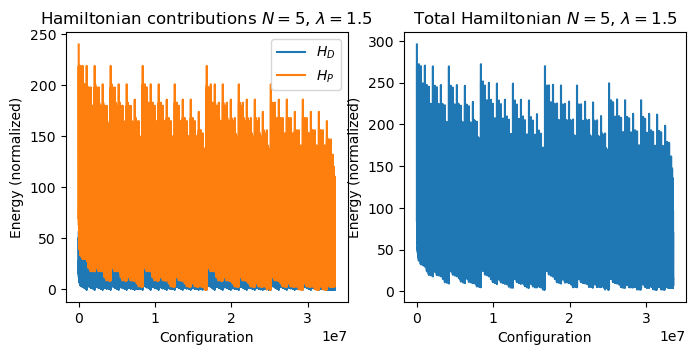

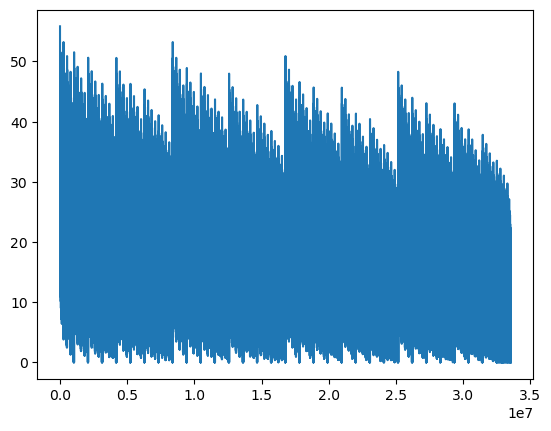

In [315]:
from itertools import product
import numpy as np

a,b = N,N

x = product([1, 0], repeat=a*b)
x = np.reshape(list(x), (-1, a,b))


plt.style.use('default')

lambdaa=1.5

energies=np.zeros(len(x))
energies2=np.zeros(len(x))
for i in range(len(x)):
    energies[i]=distance(Nr,N,x[i].reshape(1,N,N),n,Sr)
    energies2[i]=penalty(Nr, lambdaa, N,x[i].reshape(1,N,N), Sr)


fig,(ax,ax2)=plt.subplots(1,2,figsize=(8,3.5))

ax.plot(energies,label='$H_D$')
ax.plot(energies2, label='$H_P$')
ax.legend()
ax.set_title("Hamiltonian contributions $N=5$, $\lambda=1.5$")
ax.set_xlabel('Configuration')
ax.set_ylabel('Energy (normalized)')


energies3=np.zeros(len(x))
for i in range(len(x)):
    energies3[i]=energy(Nr, lambdaa, N, x[i].reshape(1,N,N), n, Sr)

ax2.plot(energies3, label='Penalties')
ax2.set_title("Total Hamiltonian $N=5$, $\lambda=1.5$")
ax2.set_xlabel('Configuration')
ax2.set_ylabel('Energy (normalized)')
fig.savefig('HN=5.eps',bbox_inches='tight')



In the next, we present the algorithms. Each algorithm is preceded by its corresponding required initialization, like the temperature schedule or the number of replicas.

Simulated Annealing Algorithm

In [144]:
########## SIMULATED ANEALING #############

In [8]:
def initializations_SA(randomnesscount):

    M=1
    xkv = np.zeros((M,1,N,N))
    solutions1v = np.zeros((M,1,N,N))
    solutions2=np.zeros(M)
    EEk=np.zeros(M)

        
    for t in range(M):
        x1=np.zeros((1,N,N))
        for i in range(N):
            for j in range(N):
                x1[0,i,j]=np.random.randint(0,2)
                randomnesscount+=1
        xkv[t]=x1
        solutions1v[t]=x1
        solutions2[t]=10000

    return M, solutions1v, solutions2, xkv, np.copy(xkv), EEk, np.copy(EEk), randomnesscount


Simulated Annealing Main Algorithm

In [9]:
######## SIMULATED ANNEALING ########
###################################################
################### Time Parameters ###############
Time=5000000
timesk_sa=np.zeros(Time)
energiestime_sa=np.zeros(Time)
distances_sa=np.zeros(Time)
penalty_sa=np.zeros(Time)

Timesnumber=3375  #Number of independent simulations

randomnessk_sa=np.zeros(Time)
###################################################
lambdaa=1.5
##################################################

totaldurationalgorithm=timer()


for c in range(Timesnumber):
    start=timer()
    randomnesscount=0
    ind=0

########################### Main algorithm ###########################################################

    M, solutions1, solutions2, xk, xk2, EEk, EEk2, randomnesscount=initializations_SA(randomnesscount)

    iterations=2000
    Temperatures=np.geomspace(5000,0.3,iterations)
    nT=N*N #Number of Monte Carlo moves

    #Calculate energy of initial random solution
    m=0
    x=xk[m]
    EE=energy(Nr,lambdaa,N,x,n,Sr)
    EEk[m]=EE

    for i in range(len(Temperatures)):
            m=0 #Replica selection (in this case, we have only 1)
            x=xk[m]
            x2=xk2[m]
            EE=EEk[m]
            T=Temperatures[i]
            x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step(Nr, lambdaa, N,
                                                       x, x2, n, T,nT, EE, m, solutions1, solutions2, Sr, randomnesscount) 

            EEk[m]=EE #Update energy of replica M with the resulting one after MC
            xk[m] = x
            xk2[m]=x2

            
#######################################################################################################

            #### The following variables are used to plot at the end the averaged quantities as a function of time
        
            if i%30==0:
                end= timer()        
                timesk_sa[ind]+=end-start
                energiestime_sa[ind]+=min(solutions2)
                randomnessk_sa[ind]+=randomnesscount
                distances_sa[ind]+=distance(Nr,N,solutions1[0],distances,Sr)
                penalty_sa[ind]+=penalty(Nr,lambdaa,N,solutions1[0],Sr)
                ind+=1
            
            
            
    print(min(solutions2)) # Best energy found in each iteration

#### Averages of the results of energies as a function of time
    
        
timesk_sa=timesk_sa
randomnessk_sa=randomnessk_sa
energiestime_sa=energiestime_sa/Timesnumber
distances_sa=distances_sa/Timesnumber
penalty_sa=penalty_sa/Timesnumber
        
        
finaldurationalgorithm=(timer()-totaldurationalgorithm)
print(f"Total duration of Simulated Annealing algorithm is {finaldurationalgorithm} seconds" )
        
    

5.131543624256902
4.099328859135072
4.394630872438397
5.170469798679619
4.91543624161017
4.485906040329593
5.538255033526062
5.2872483221608775
5.452348993435472
4.182550335560267
5.02416107389639
4.578523489912593
4.4805369128075965
4.938255033580367
4.775838926070646
4.883221476447037
4.452348993291339
5.55704697972382
4.379865771754195
4.175838926117949
4.825503355602012
4.342281879166225
5.489932885824411
4.74093959727904
5.342281879231238
4.965100671055584
4.915436241552967
4.354362416189295
4.428187919507721
4.202684563764864
3.672483221526111
4.523489932835705
4.900671140940052
5.343624161049213
4.387919462974286
4.87248322142913
4.708724832154095
4.66711409387789
4.38389261737772
4.624161073816958
5.322147651070485
4.44563758385976
4.946308724839139
4.830872483337959
4.997315436213919
4.834899328883593
4.989261744829826
4.751677852374409
4.107382550306697
4.594630872541337
4.861744966510888
4.75570469802539
4.006711409406583
4.598657718112298
4.570469798633505
4.782550335599168

List Based Simulated Annealing Algorithm

In [10]:
########LIST BASED SIMULATED ANNEALING########
def initializations_listbased(randomnesscount):

    M=1
    xkv = np.zeros((M,1,N,N))
    solutions1v = np.zeros((M,1,N,N))
    solutions2=np.zeros(M)
    EEk=np.zeros(M)
   
    for t in range(M):
        x1=np.zeros((1,N,N))
        for i in range(N):
            for j in range(N):
                x1[0,i,j]=np.random.randint(0,2)   
                randomnesscount+=1
        xkv[t]=x1
        solutions1v[t]=x1
        solutions2[t]=10000
    Lmax=100  #Maximum length of the list
    p0=0.99 #Initial acceptance probability to find out initial temperature list
    
    return M, solutions1v, solutions2, xkv,np.copy(xkv), EEk,np.copy(EEk),p0,Lmax, randomnesscount


Functions to create the initial temperature list and the Monte Carlo sweeps for the LBSA.

In [11]:
## Initial temperature list creation.
@njit
def metropolis_update_listcreation(listt, Nr, lambdaa, N, x, x2,
                       n, p0, EE, i, j, k, ri, Sr):
    x_old=x2
    x[ri][i][j] = 1-x[ri][i][j]
    energydiff=energy_difference(x,x_old,ri,i,j,lambdaa)
    Enew=energydiff+EE

    if(Enew < EE):
        x_old[ri][i][j] = 1-x_old[ri][i][j]
        t=-abs(Enew-EE)/np.log(p0)
        listt[k]=t
        return listt,Enew,x,x_old
    else:
        x[ri][i][j] = 1-x[ri][i][j]
        t=-abs(Enew-EE)/np.log(p0)
        listt[k]=t
        return listt,EE,x,x_old        
       
@njit
def thermalization_step_listcreation(Nr, lambdaa, N, x, x2, n, p0,
                         Lmax, listt, EE, solutions1k, solutions2k, Sr, randomnesscount):  
    for k in range(Lmax):
        ri=np.random.randint(0,Nr)
        i=np.random.randint(0,Sr[ri])
        j=np.random.randint(0,N)
        randomnesscount+=3 ###
        listt,EE,x,x2 = metropolis_update_listcreation(listt, Nr,lambdaa,N,x,x2,n,p0,EE,i,j,k,ri,Sr)
        if(EE < solutions2k[m]):
            solutions1k[m]=np.copy(x)
            solutions2k[m]=EE
    return listt,x,np.copy(x),EE,solutions1k,solutions2k, randomnesscount

### Functions used for the main algorithm

@njit
def metropolis_update_list(t,c,Nr, lambdaa, N, x, x2,
                       n,T, EE, i, j, k, ri, Sr, randomnesscount):

    x_old=x2
    x[ri][i][j] = 1-x[ri][i][j]

    energydiff=energy_difference(x,x_old,ri,i,j,lambdaa)
    Enew=energydiff+EE
    if(Enew < EE): ####
        x_old[ri][i][j] = 1-x_old[ri][i][j]
        return t,c,Enew,x,x_old, randomnesscount
    threshold = np.exp((EE-Enew)/T)
    randomnumber=np.random.rand()
    randomnesscount+=1 ###
    if randomnumber < threshold:
        x_old[ri][i][j] = 1-x_old[ri][i][j]
        t=t+(-Enew+EE)/np.log(randomnumber)
        c=c+1
        return t,c,Enew,x,x_old, randomnesscount
    else:
        x[ri][i][j] = 1-x[ri][i][j]
        return t,c,EE,x,x_old, randomnesscount

@njit
def thermalization_step_list(t,c,Nr, lambdaa, N, x, x2, n,T,
                         nT, EE, solutions1k, solutions2k, Sr, randomnesscount):  
    for k in range(nT):
        
        ri=np.random.randint(0,Nr)
        i=np.random.randint(0,Sr[ri])
        j=np.random.randint(0,N)
        randomnesscount+=3 ###
        t,c,EE,x,x2, randomnesscount = metropolis_update_list(t,c,Nr,lambdaa,N,x,x2,n,T,EE,i,j,k,ri,Sr, randomnesscount)
        if(EE < solutions2k[m]):
                solutions1k[m]=np.copy(x)
                solutions2k[m]=EE
    return t,c,x,np.copy(x),EE,solutions1k,solutions2k, randomnesscount


@njit
def list_modification(listt,c,t,list2,iterationsk):
    if c!=0:
        index=np.where(max(listt)==listt)
        index=index[0][0]  
        listt=np.delete(listt,index)
        listt=np.append(listt,t/c)
    list2[k]=max(listt)
    iterationsk[k]=k
    
    return listt,list2,iterationsk

List Based Simulated Annealing Main Algorithm

In [12]:
########LIST BASED SIMULATED ANNEALING########
###################################################
################### Time Parameters ###############
Time=50000000
timesk_lbsa=np.zeros(Time)
energiestime_lbsa=np.zeros(Time)
Timesnumber=3375  #Number of independent simulations 


randomnessk_lbsa=np.zeros(Time)
distances_lbsa=np.zeros(Time)
penalty_lbsa=np.zeros(Time)
###################################################
lambdaa=1.5
###################################################

totaldurationalgorithm=timer()



for c in range(Timesnumber):
    start=timer()
    randomnesscount=0
    ind=0

####################################### Main Algorithm #################################################

    # Initialization of initial random solutions 
    M, solutions1, solutions2, xk,xk2, EEk,EEk2,p0,Lmax, randomnesscount=initializations_listbased(randomnesscount)
    listt=np.zeros(Lmax)

    ### Creation of initial list of temperatures
    m=0 #Replica selection (in this case, we have only 1)
    EE=energy(Nr, lambdaa, N, xk[0], n, Sr)
    listt,x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step_listcreation(Nr, lambdaa, N, xk[0], xk2[0], n, p0,
                             Lmax, listt, EE, solutions1, solutions2, Sr, randomnesscount)

    xk[0]=x
    xk2[0]=x2
    EEk[0]=EE
    EEk2[0]=EE

    iterations=2000
    list2=np.zeros(iterations)
    iterationsk=np.zeros(iterations)
    nT=N*N #Number of Monte Carlo moves
    
    for k in range(iterations):
        T=max(listt)
        t=0
        c=0
        x=xk[0]
        x2=xk2[0]
        EE=EEk[0]
        t,c,x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step_list(t,c,Nr, lambdaa, N, x, x2, n,T,
                             nT, EE, solutions1, solutions2, Sr, randomnesscount)        
        EEk[0]=EE
        
        # After the Monte Carlo sweeps are performed, the temperature list is updated with the average of the temperatures found.        
        listt,list2,iterationsk =list_modification(listt,c,t,list2,iterationsk)       
    
####################################### Main Algorithm #################################################
      
        
        #### The following variables are used to plot at the end the averaged quantities as a function of time
        if k%30==0:
            end= timer() 
            timesk_lbsa[ind]+=end-start
            energiestime_lbsa[ind]+=min(solutions2)
            randomnessk_lbsa[ind]+=randomnesscount
            distances_lbsa[ind]+=distance(Nr,N,solutions1[0],distances,Sr)
            penalty_lbsa[ind]+=penalty(Nr,lambdaa,N,solutions1[0],Sr)
            ind+=1


    print(min(solutions2))


#### Averages of the results of energies as a function of time
    
timesk_lbsa=timesk_lbsa
randomnessk_lbsa=randomnessk_lbsa
energiestime_lbsa=energiestime_lbsa/Timesnumber
distances_lbsa=distances_lbsa/Timesnumber
penalty_lbsa=penalty_lbsa/Timesnumber
    
finaldurationalgorithm=(timer()-totaldurationalgorithm)
print(f"Total duration of List Based Simulated Annealing algorithm is {finaldurationalgorithm} seconds" )

4.257718120842553
4.402684563847251
3.8845637584093313
3.7436241610339414
4.339597315439239
4.426845637550793
4.479194630878322
3.3785234899327694
4.255033557040424
4.934228187920878
4.233557047036476
4.440268456394454
4.017449664470001
4.430872483229244
4.720805369101434
4.70872483221542
4.53154362410883
4.542281879231194
4.735570469763276
4.446979865828301
4.2657718121399135
4.834899328899047
4.2000000000130555
4.385234899366311
4.393288590610547
4.62953020133572
4.304697986579599
4.2939597315519205
3.920805369032541
4.263087248338363
4.511409395965114
4.569127516824869
3.7570469798622317
4.891275167747331
4.265771812055263
4.621476510086903
4.616107382581357
4.102013422836938
3.808053691316323
4.5718120805459215
4.429530201383484
4.1825503355558435
4.2483221475970065
4.304697986571612
4.778523489975143
3.991946308697912
4.373154362436012
4.342281879259671
4.355704697993536
4.531543624144538
4.374496644290309
4.324832214748197
4.590604026816861
4.497986577199535
3.9355704697396776
4.

Population Annealing Algorithm

In [10]:
########POPULATION ANNEALING########

In [13]:
@njit
def initializations_popann(randomnesscount):
    
    M=22500 #Number of replicas of the tempering

    fluct=M+int(3*math.sqrt(M))
    xkv = np.zeros((fluct,1,N,N))
    solutions1v = np.zeros((fluct,1,N,N))
    solutions2=np.zeros(fluct)
    EEk=np.zeros(fluct)

        
    for t in range(M):
        x1=np.zeros((1,N,N))
        for i in range(N):
            for j in range(N):
                x1[0,i,j]=np.random.randint(0,2)   
                randomnesscount+=1 ###
        xkv[t]=x1
        solutions1v[t]=x1
        solutions2[t]=10000
        
    return M, solutions1v, solutions2, xkv,np.copy(xkv), EEk,np.copy(EEk), randomnesscount

The following functions are used to remove and append the replicas dictated by the stochastic resampling step:

In [14]:
@njit
def concatenate(Rbetaa,Rbeta,num_cop,restoreposition,xk,xk2,EEk,EEk2,i):
        dontmultiply=0
        if num_cop!=0:
            target=xk2[i]
            xk[restoreposition]=0
            EEk[restoreposition]=0
            targetenergy=EEk2[i]
            for j in range(num_cop):    
                EEk[restoreposition+j]=targetenergy
                xk[restoreposition+j]=target  
            restoreposition+=num_cop


        else:
            dontmultiply=1
            target=0
            targetenergy=0
            xk[restoreposition]=target
            EEk[restoreposition]=targetenergy
            
        Rbeta+=num_cop-1  

        return Rbeta,restoreposition,xk,EEk,i
    
@njit
def erase_when_less_resampled(restoreposition,Rbetaa,xk,EEk):
        for k in range(restoreposition,Rbetaa):
            EEk[k]=0
            xk[k]=0
        return xk,EEk
   


@njit
def weights_and_resampling(Rbeta,beta1,beta2,M,randomnesscount,xk,xk2,EEk,EEk2):
    weightk=[]

    for m in range(Rbeta):
        EE=EEk[m]
        argum=-(beta2-beta1)*(EE)
        weightk.append(np.exp(argum))

    sum_weight=sum(weightk)
    Q=sum_weight/Rbeta
    
    Rbetaa=Rbeta
    norm_weightk=[]
    restoreposition=0
    for i in range(Rbetaa): #Loop to compute normalized weight corresponding to each replica
        norm_weight=Rbetaa*Q

        norm_weight=(M*weightk[i])/norm_weight

        norm_weightk.append(norm_weight)

        probab=norm_weight-math.floor(norm_weight)
        randomnumber=random.random()
        randomnesscount +=1 ###
        if randomnumber<probab:
            num_cop=math.ceil(norm_weight)
        else:
            num_cop=math.floor(norm_weight)

        Rbeta,restoreposition,xk,EEk,i=concatenate(Rbetaa,Rbeta,num_cop,restoreposition,xk,xk2,EEk,EEk2,i) #Append the reproduced replicas

    xk,EEk=erase_when_less_resampled(restoreposition,Rbetaa,xk,EEk)
    xk2=np.copy(xk)
    EEk2=np.copy(EEk)
    
    return xk,xk2,EEk,EEk2,Rbeta,Rbetaa,randomnesscount

Population Annealing Main Algorithm

In [35]:
######## POPULATION ANNEALING ########

###################################################
################### Time Parameters ###############
Numberit=30 #Number of iterations of main loop

Time=50000000
timesk_pa=np.zeros(Time)
energiestime_pa=np.zeros(Time)
Timesnumber=10 #Number of independent simulations


randomnessk_pa=np.zeros(Time)
distances_pa=np.zeros(Time)
penalty_pa=np.zeros(Time)
randomnesscount=0

###################################################
lambdaa=1.5
###################################################

totaldurationalgorithm=timer()


for pp in range(Timesnumber):
    start = timer()
    randomnesscount=0
    ind=0
    
####################################### Main Algorithm #################################################

    Betas=np.linspace(0,3.3,Numberit) # Temperature schedule
    nT=N * N #Number of Monte Carlo moves

    M, solutions1, solutions2, xk,xk2, EEk,EEk2, randomnesscount = initializations_popann(randomnesscount)

    Rbeta=M #Define our Rbeta so that our population size does not fluctuate much with respect the previous one after resampling   
    
    for m in range(Rbeta):
        x = xk[m]
        EE = energy(Nr,lambdaa,N,x,n,Sr)
        EEk[m]=EE
        EEk2[m]=EE    
    
    
    for j in range(Numberit): #Main loop
        if j==Numberit-1:
            continue
        beta1 = Betas[j] #We pick first temperature of our range
        beta2 = Betas[j+1] #Pick next lower temperature of our list that will affect our replicas
        
        #Perform resampling step
        xk,xk2,EEk,EEk2,Rbeta,Rbetaa,randomnesscount =    weights_and_resampling(Rbeta,beta1,beta2,M,randomnesscount,xk,xk2,EEk,EEk2)
        

        for m in range(Rbeta): #After resampling at that reduced temperature, we perform the nT Monte Carlo moves to each replica
            x = xk[m] #Select solution spin of replica m
            x2 = xk2[m]
            EE = EEk[m]
            T=1/beta2
            x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step(Nr, lambdaa, N,
                                                           x, x2, n, T,nT, EE, m, solutions1, solutions2, Sr, randomnesscount)  
            

            EEk[m]=EE #Update energy of replica M with the resulting one after MC
            EEk2[m]=EE
            xk[m] = x
            xk2[m]=x2
            
####################################### Main Algorithm #################################################           

            #### The following variables are used to plot at the end the averaged quantities as a function of time

            if m%40==0:
                end= timer()        
                timesk_pa[ind]+=end-start
                energiestime_pa[ind]+=np.min(solutions2[np.nonzero(solutions2)])
                randomnessk_pa[ind]+=randomnesscount
                distances_pa[ind]+=distance(Nr,N,solutions1[np.where(solutions2==np.min(solutions2[np.nonzero(solutions2)]))[0][0]],distances,Sr)
                penalty_pa[ind]+=penalty(Nr,lambdaa,N,solutions1[np.where(solutions2==np.min(solutions2[np.nonzero(solutions2)]))[0][0]],Sr)                
                
                ind+=1
                
        print(min(i for i in solutions2 if i > 0))

#### Averages of the results of energies as a function of time
    
maximumindex=np.where(timesk_pa==max(timesk_pa))[0][0] ##Consider this since in each independent simulation the final number of replicas may differ
timesk_pa=timesk_pa[:maximumindex] 
energiestime_pa=energiestime_pa[:maximumindex]
randomnessk_pa=randomnessk_pa[:maximumindex]
distances_pa=distances_pa[:maximumindex]
penalty_pa=penalty_pa[:maximumindex]


timesk_pa=timesk_pa/Timesnumber
energiestime_pa=energiestime_pa/Timesnumber   
randomnessk_pa=randomnessk_pa/Timesnumber
distances_pa=distances_pa/Timesnumber
penalty_pa=penalty_pa/Timesnumber

    
    
finaldurationalgorithm=(timer()-totaldurationalgorithm)
print(f"Total duration of Population Annealing algorithm is {finaldurationalgorithm} seconds" )


166.19060402684485
36.05771812080533
19.6536912751679
15.340939597314712
11.420134228187738
8.79865771812058
7.727516778523678
5.660402684563827
4.852348993288198
4.363758389260938
4.3557046979867815
4.355704697986781
4.08724832214785
4.069798657718279
3.445637583891801
3.445637583891801
3.445637583891801
3.445637583891801
3.3006711409397096
3.3006711409397096
3.3006711409397096
3.3006711409397096
3.2765100671132767
3.2765100671132767
3.2765100671132767
3.2765100671132767
3.2765100671132767
3.2765100671132767
3.2765100671132767
143.42281879194644
33.49261744966453
22.608053691274637
12.885906040267983
11.146308724831911
8.620134228188062
7.578523489932372
6.511409395972631
4.946308724832297
4.691275167785262
3.83087248322163
3.83087248322163
3.6080536912747445
3.6080536912747436
3.5718120805369784
3.5718120805369784
3.5718120805369784
3.5718120805369784
3.5718120805369784
3.5718120805369784
3.5503355704692643
3.5503355704692643
3.5503355704692643
3.5503355704692643
3.5503355704692643
3

Parallel Tempering Monte Carlo Algorithm

In [16]:
########PARALLEL TEMPERING MONTE CARLO########

@njit
def initializations(randomnesscount):
    M=30 #Number of replicas of the tempering
    T1=0.3 #First temperature of our range
    Tm=5000 #Last temperature of our range
    
    R=np.zeros(M)
    Tgeom=np.zeros(M)
    for i in range(M):
        R[i]=(Tm/T1)**(1/(M-1))  
    for k in range(M):
        if k+1==M+1:
            continue    
        Tgeom[k-1]=T1*np.prod(R[:k-1])
    Tgeom[0]=T1
    Tgeom[M-1]=Tm
    Temps=Tgeom 

    EEk=np.zeros(M)
    xkv = np.zeros((M,1,N,N))
    solutions1v = np.zeros((M,1,N,N))
    solutions2=np.zeros(M)
    
    for t in range(M):
        x1=np.zeros((1,N,N))
        for i in range(N):
            for j in range(N):
                x1[0,i,j]=np.random.randint(0,2) 
                randomnesscount+=1###

        xkv[t]=x1
        solutions1v[t]=x1
        solutions2[t]=10000
                
    return M,Temps, solutions1v, solutions2, xkv,np.copy(xkv), EEk, randomnesscount

The following function is used to perform the exchange moves of replicas.

In [17]:
### PARALLEL TEMPERING

@njit
def replicaexchange_pt(order,M,indexTmove,up,down,nup,ndown,Temps_in,EEk,moveacc,randomnesscount):

    np.random.shuffle(order)
    randomnesscount+=1 ###
    for v in range(M): #Main loop for swapping replicas
        s=order[v]
        for c in range(M):
            if up[indexTmove[c]]==1:
                nup[c]=nup[c]+1
            if down[indexTmove[c]]==1:
                ndown[c]=ndown[c]+1                
                
        if s!=M-1:                    
            argum=(1/Temps_in[s+1]-1/Temps_in[s])*(EEk[s+1]-EEk[s])
            r = np.random.rand() #Throw a dice to see if we do the swap of replicas or not
            randomnesscount+=1 ###

            if argum>=0 or math.exp(argum)>r: #If the value of dice smaller than previous probability, we swap the temperatures of replicas
                T1move=indexTmove[s]
                indexTmove[s]=indexTmove[s+1]
                indexTmove[s+1]=T1move
                EEmove=EEk[s]
                EEk[s]=EEk[s+1]
                EEk[s+1]=EEmove
                moveacc[s]=moveacc[s]+1


                up[indexTmove[0]]=1
                down[indexTmove[0]]=0

                down[indexTmove[M-1]]=1
                up[indexTmove[M-1]]=0
 
    return up,down,nup,ndown,indexTmove,moveacc,EEk,randomnesscount
            

Parallel Tempering Monte Carlo Main Algorithm

In [18]:
#### PARALLEL TEMPERING MONTE CARLO
###################################################
################### Time Parameters ###############
Time=50000000
timesk_pt=np.zeros(Time)
energiestime_pt=np.zeros(Time)
distances_pt=np.zeros(Time)
penalty_pt=np.zeros(Time)
Timesnumber=10 #Number of independent simulations
randomnessk_pt=np.zeros(Time)
randomnesscount=0
###################################################
lambdaa=1.5
###################################################




M,Temps_in, solutions1, solutions2, xk,xk2, EEk,randomnesscount=initializations(randomnesscount)
MPT=M
Nmainiter=5 #Number of feedback iterations
totaldurationalgorithm=timer()

fractionk_meaniter=np.zeros((Nmainiter-1,1,M)) ##
accprobk_meaniter=np.zeros((Nmainiter-1,1,M-1)) ##
Temps_ink_meaniter=np.zeros((Nmainiter,1,M)) ##
Temps_ink_meaniter[0]+=Temps_in ##

for pp in range(Timesnumber):
    start = timer()
    randomnesscount=0
    ind=0

####################################### Main Algorithm #################################################  


    M,Temps_in, solutions1, solutions2, xk,xk2, EEk,randomnesscount=initializations(randomnesscount)


    print("Initial temperatures are")
    print(Temps_in)

    #Main algorithm
    Nswapsiter=1500
    Nburnin=0 #It is possible to add a certain number of swaps in the first iteration that will not be considered for the 
              #first feedback step to avoid the useless statistics of first Monte Carlo moves. 
              #In case of PT, we may do this as a sanity check.
    nT=N*N #Number of Monte Carlo moves

    fractionkv=np.zeros((Nmainiter-1,1,M))
    accprobkv=np.zeros((Nmainiter-1,1,M-1))
    Temps_inkv=np.zeros((Nmainiter,1,M))
    Temps_inkv[0]=Temps_in
    veckv=np.zeros((Nmainiter,1,M))
    veckv[0]=0*np.ones(M)


    order = np.arange(M)
   

    indexTmove=np.zeros(len(Temps_in),dtype=int)
    for i in range(len(Temps_in)):
        indexTmove[i]=int(i)
       
    for m in range(M): #Loop for computing the initial energies corresponding of each randomly initialized replica m of our list
        x=xk[indexTmove[m]]
        x2=xk2[indexTmove[m]]
        EE=energy(Nr,lambdaa,N,x,n,Sr)
        xk[indexTmove[m]]=x
        xk2[indexTmove[m]]=x2
        EEk[m]=EE            

        
        
    for g in range(Nmainiter):
            Nswaps=Nswapsiter
        
            if g==0: #In case we opt to use a certain number of burning Nswaps.
                Nswaps=Nburnin
        
            up=np.zeros(M)
            down=np.zeros(M)      
            up[indexTmove[0]]=1
            down[indexTmove[M-1]]=1
            nup=np.zeros(M)
            ndown=np.zeros(M)
            moveacc=np.zeros(M-1)

            for p in range(Nswaps): #Main loop of the tempering

                if p%10==0:
                    print(p)

                for m in range(M): #Loop for computing the Monte Carlo moves at each replica m of our list
                    x=xk[indexTmove[m]]
                    x2=xk2[indexTmove[m]]
                    EE=EEk[m]

                    T=Temps_in[m]
                    x,x2,EE,solutions1,solutions2,randomnesscount=thermalization_step(Nr, lambdaa, N,
                                                                   x, x2, n, T,nT, EE, m, solutions1, solutions2, Sr,randomnesscount)

                    xk[indexTmove[m]]=x
                    xk2[indexTmove[m]]=x2
                    EEk[m]=EE
 
                #Perform the replica exchange step
                up,down,nup,ndown,indexTmove,moveacc,EEk,randomnesscount=replicaexchange_pt(order,M,indexTmove,up,down,
                                                                         nup,ndown,Temps_in,EEk,moveacc,randomnesscount)
                        
####################################### Main Algorithm #################################################           
  
                #### The following variables are used to plot at the end the averaged quantities as a function of time
                end= timer()        
                timesk_pt[ind]+=end-start
                energiestime_pt[ind]+=np.min(solutions2)
                distances_pt[ind]+=distance(Nr,N,solutions1[np.where(solutions2==np.min(solutions2))[0][0]],distances,Sr)
                penalty_pt[ind]+=penalty(Nr,lambdaa,N,solutions1[np.where(solutions2==np.min(solutions2))[0][0]],Sr)
                randomnessk_pt[ind]+=randomnesscount
                ind+=1
                      
##############################

            print("Best energy found up to now")
            print(min(solutions2))
        
        
            if g==0: #Abort burn-in
                continue

            #Fraction of replicas visiting the two extremal temperatures
            fraction=np.zeros(M)
            for i in range(M): #Loop calculating fraction of replicas visiting the extremal temperatures
                if nup[i]==0:
                    fraction[i]=0
                else:
                    fraction[i]=nup[i]/(nup[i]+ndown[i])

            print("Number of ups")
            print(nup)
            print("Number of downs")
            print(ndown)
            print(EEk)
            print("Fraction is")
            print(fraction)
            print("Acceptance probabilities are")
            accprob=moveacc/Nswaps
            print(accprob)          

            Nswapsiter=Nswapsiter*2 #Increment the number of swaps by 2
            print("New temperatures set is")
            Temps_in=np.asarray(Temps_in)
            print(Temps_in)

            fractionk=fraction.reshape(1,1,M)
            fractionkv[g-1]=fractionk
            
            fractionk_meaniter[g-1]=fractionk_meaniter[g-1]+fractionk ####
            
            accprobk=accprob.reshape(1,1,M-1)
            accprobkv[g-1]=accprobk
            accprobk_meaniter[g-1]=accprobk_meaniter[g-1]+accprobk            
            

            vec=np.ones(M)
            vec=(g)*vec  
            veck=vec.reshape(1,1,M)    
            veckv[g]=veck

            Temps_ink=Temps_in.reshape(1,1,M)
            Temps_inkv[g]=Temps_ink
            
            Temps_ink_meaniter[g]=Temps_ink_meaniter[g]+Temps_ink ####
             


#### Averages of the results as a function of time
       
timesk_pt=timesk_pt/Timesnumber
energiestime_pt=energiestime_pt/Timesnumber 
randomnessk_pt=randomnessk_pt/Timesnumber
distances_pt=distances_pt/Timesnumber
penalty_pt=penalty_pt/Timesnumber

fractionk_meaniter=fractionk_meaniter/Timesnumber ###
Temps_ink_meaniter=Temps_ink_meaniter/Timesnumber ###
accprobk_meaniter=accprobk_meaniter/Timesnumber ###

Temps_ink_meaniter[0]=Temps_ink_meaniter[0]*Timesnumber ##
    
finaldurationalgorithm=(timer()-totaldurationalgorithm)
print(f"Total duration of Parallel Tempering algorithm is {finaldurationalgorithm} seconds" ) 

Temperatures are
[3.00000000e-01 4.19471294e-01 5.86520556e-01 8.20095122e-01
 1.14668787e+00 1.60334216e+00 2.24185337e+00 3.13464378e+00
 4.38297694e+00 6.12844337e+00 8.56902023e+00 1.19815267e+01
 1.67530217e+01 2.34247057e+01 3.27533053e+01 4.57969046e+01
 6.40349562e+01 8.95360865e+01 1.25192727e+02 1.75049184e+02
 2.44760359e+02 3.42233149e+02 4.78523273e+02 6.69089256e+02
 9.35545787e+02 1.30811534e+03 1.82905612e+03 2.55745512e+03
 3.57593003e+03 5.00000000e+03]
[3.00000000e-01 4.19471294e-01 5.86520556e-01 8.20095122e-01
 1.14668787e+00 1.60334216e+00 2.24185337e+00 3.13464378e+00
 4.38297694e+00 6.12844337e+00 8.56902023e+00 1.19815267e+01
 1.67530217e+01 2.34247057e+01 3.27533053e+01 4.57969046e+01
 6.40349562e+01 8.95360865e+01 1.25192727e+02 1.75049184e+02
 2.44760359e+02 3.42233149e+02 4.78523273e+02 6.69089256e+02
 9.35545787e+02 1.30811534e+03 1.82905612e+03 2.55745512e+03
 3.57593003e+03 5.00000000e+03]
[4158.35436242 4022.65503356 3792.18255034 3561.37986577 2975.088

Feedback Optimized Parallel Tempering Monte Carlo Algorithm

In [ ]:
######### FEEDBACK OPTIMIZED PARALLEL TEMPERING MONTE CARLO

The following functions are required in order to calculate a new optimized temperature set after each iteration:

In [19]:
#### FUNCTIONS TO CALCULATE OPTIMIZED TEMPERATURE SET

@njit
def estimate_coef(x, y): #To compute the coefficients of the linear regression
    
    # Number of observations/points
    n = len(x)
    # Mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)

    # Calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
  
    # Calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)

@njit
def deltat(k,Temps_in): #Function calculating the dT of the integral
    return Temps_in[k+1]-Temps_in[k]

@njit
def dfdt(k,Temps_in,M,fraction): #Function calculating the derivative at each temperature point T_i

    global norepk
    norep=0
    derivative=1
    while derivative>0: #In case the derivative is not negative, we need to consider extra points to do the linear regression.
        if norep==0:
            norep=int(norep)
        if k==0:
            b,derivative=estimate_coef(Temps_in[k:k+2], fraction[k:k+2])
        else:
            b,derivative=estimate_coef(Temps_in[k-1:k+2], fraction[k-1:k+2])
        
        if norep!=0:
            norep=int(norep)
            if k+2+norep<=(M):
                if k-1-norep<0:
                    g=0
                    while k-1-norep+g<0:
                        g=g+1
                    b,derivative=estimate_coef(Temps_in[k-1-norep+g:k+2+norep], fraction[k-1-norep+g:k+2+norep])
                if k-1-norep>=0:
                    b,derivative=estimate_coef(Temps_in[k-1-norep:k+2+norep], fraction[k-1-norep:k+2+norep])     
            else:
                i=0
                while k+2+norep-i>(M):
                    i=i+1                        
                if k-1-norep<0:    
                    j=0
                    while k-1-norep+j<0:
                        j=j+1
                    b,derivative=estimate_coef(Temps_in[k-1-norep+j:k+2+norep-i], fraction[k-1-norep+j:k+2+norep-i])
                if k-1-norep>=0:
                    b,derivative=estimate_coef(Temps_in[k-1-norep:k+2+norep-i], fraction[k-1-norep:k+2+norep-i])

        if derivative>0:
            norep=norep+1
    return derivative

@njit
def eta(k,Temps_in,M,fraction): #Function calculating the density distribution eta, indicating the probability for a
                                #replica to reside at temperature T
    return (-dfdt(k,Temps_in,M,fraction)/deltat(k,Temps_in))**(1/2)

@njit
def norm(Temps_in,M,fraction): #Function calculating the norm of the eta
    contribution=[]
    for k in range(M-1):
        contribution.append(eta(k,Temps_in,M,fraction)*deltat(k,Temps_in))
    return sum(contribution)

@njit
def eta_norm(k,Temps_in,M,fraction): #Eta normalized
    C=1/norm(Temps_in,M,fraction) #Norm coefficient
    return C*(-dfdt(k,Temps_in,M,fraction)/deltat(k,Temps_in))**(1/2)

@njit
def tcalc(Temps_in,M,fraction): #Function returning the optimized temperature set
    deltatv=[]
    for k in range(M-1):
        deltatv.append(deltat(k,Temps_in))
    N=len(deltatv)
    T_prime=[]
    T_prime.append(Temps_in[0])
    n=0
    n_prime=0
    k=0
    this_deltaT=0 
 
    while (n<N and k<N):
        if n_prime + N*eta_norm(k,Temps_in,M,fraction)*deltatv[k] >= (n+1): 
            tau = (n - n_prime + 1)/(eta_norm(k,Temps_in,M,fraction) *N)
            this_deltaT += tau;
            T_prime.append(T_prime[-1] + this_deltaT )
            n=n+1
            n_prime += eta_norm(k,Temps_in,M,fraction) *N* tau
            deltatv[k] -= tau
            this_deltaT = 0
        else:
            n_prime += N*eta_norm(k,Temps_in,M,fraction) * deltatv[k]
            this_deltaT += deltatv[k];
            k=k+1;
        if k==N:
            T_prime.append(Temps_in[-1])
    
    T_prime[-1]=Temps_in[-1]
    return T_prime

In [20]:
###FEEDBACK OPTIMIZED PARALLEL TEMPERING

@njit
def initializations_fopt(randomnesscount):
    M=30 #Number of replicas of the tempering
    T1=0.3 #First temperature of our range
    Tm=5000 #Last temperature of our range
    R=np.zeros(M)
    Tgeom=np.zeros(M)
    for i in range(M):
        R[i]=(Tm/T1)**(1/(M-1))  
    for k in range(M):
        if k+1==M+1:
            continue    
        Tgeom[k-1]=T1*np.prod(R[:k-1])
    Tgeom[0]=T1
    Tgeom[M-1]=Tm
    Temps=Tgeom  #We use the geometric temperature schedule
    
    #Initialization of vectors
    EEk=np.zeros(M)
    xkv = np.zeros((M,1,N,N))
    solutions1v = np.zeros((M,1,N,N))
    solutions2=np.zeros(M)

    for t in range(M):
        x1=np.ones((1,N,N))
        for i in range(N):
            for j in range(N):
                x1[0,i,j]=np.random.randint(0,2) 
                randomnesscount+=1
        xkv[t]=x1
        solutions1v[t]=x1
        solutions2[t]=10000
           
    return M,Temps, solutions1v, solutions2, xkv,np.copy(xkv), EEk, randomnesscount

The following function is used to perform the exchange moves of replicas:

In [21]:
###FEEDBACK OPTIMIZED PARALLEL TEMPERING

@njit
def replicaexchange(order,M,indexTmove,up,down,nup,ndown,Temps_in,EEk,moveacc, randomnesscount):

    np.random.shuffle(order)
    randomnesscount+=1 ###
    
    for v in range(M): #Main loop for swapping replicas
        s=order[v]
        for c in range(M):
            if up[indexTmove[c]]==1:
                nup[c]=nup[c]+1
            if down[indexTmove[c]]==1:
                ndown[c]=ndown[c]+1                
                

        if s!=M-1:                    
            argum=(1/Temps_in[s+1]-1/Temps_in[s])*(EEk[s+1]-EEk[s])
            r = np.random.rand() #Throw a dice to see if we do the swap of replicas or not
            randomnesscount+=1 ##

            if argum>=0 or math.exp(argum)>r: #If the value of dice smaller than previous probability, we swap the temperatures of replicas
                T1move=indexTmove[s]
                indexTmove[s]=indexTmove[s+1]
                indexTmove[s+1]=T1move
                EEmove=EEk[s]
                EEk[s]=EEk[s+1]
                EEk[s+1]=EEmove
                moveacc[s]=moveacc[s]+1


                up[indexTmove[0]]=1
                down[indexTmove[0]]=0

                down[indexTmove[M-1]]=1
                up[indexTmove[M-1]]=0


    
    return up,down,nup,ndown,indexTmove,moveacc,EEk, randomnesscount
            

Feedback Optimized Parallel Tempering Main Algorithm

In [22]:
####FEEDBACK OPTIMIZED PARALLEL TEMPERING
###################################################
################### Time Parameters ###############
Time=50000000
timesk_fopt=np.zeros(Time)
energiestime_fopt=np.zeros(Time)
Timesnumber=10 #Number of independent simulations

randomnessk_fopt=np.zeros(Time)
distances_fopt=np.zeros(Time)
penalty_fopt=np.zeros(Time)
randomnesscount=0
###################################################
lambdaa=1.5
###################################################
M,Temps_in, solutions1, solutions2, xk,xk2, EEk, randomnesscount=initializations_fopt(randomnesscount)
Nmainiter=5 #Number of feedback iterations
totaldurationalgorithm=timer()

fractionk_meaniter_fopt=np.zeros((Nmainiter-1,1,M)) ##
accprobk_meaniter_fopt=np.zeros((Nmainiter-1,1,M-1)) ##
Temps_ink_meaniter_fopt=np.zeros((Nmainiter,1,M)) ##
Temps_ink_meaniter_fopt[0]+=Temps_in ##


for pp in range(Timesnumber):
    start = timer()
    ind=0
    randomnesscount=0

####################################### Main Algorithm ################################################# 

    #Initialize everything
    M,Temps_in, solutions1, solutions2, xk,xk2, EEk, randomnesscount=initializations_fopt(randomnesscount)
    


    print("Initial starting temperatures are")
    print(Temps_in)

    #Main algorithm
    Nswapsiter=1500
    nT=N*N #Number of Monte Carlo moves
    Nburnin=0 #It is possible to add a certain number of swaps in the first iteration that will not be considered for the 
              #first feedback step to avoid the useless statistics of first Monte Carlo moves.

    fractionkv=np.zeros((Nmainiter-1,1,M))
    accprobkv=np.zeros((Nmainiter-1,1,M-1))
    Temps_inkv=np.zeros((Nmainiter,1,M))
    Temps_inkv[0]=Temps_in
    veckv=np.zeros((Nmainiter,1,M))
    veckv[0]=0*np.ones(M)

    order = np.arange(M)    
    
    indexTmove=np.zeros(len(Temps_in),dtype=int)
    for i in range(len(Temps_in)):
        indexTmove[i]=int(i)
        

    for m in range(M): #Loop for computing the initial energies corresponding of each randomly initialized replica m of our list
        x=xk[indexTmove[m]]
        x2=xk2[indexTmove[m]]
        EE=energy(Nr,lambdaa,N,x,n,Sr)
        xk[indexTmove[m]]=x
        xk2[indexTmove[m]]=x2
        EEk[m]=EE

    for g in range(Nmainiter):
            Nswaps=Nswapsiter
        
            if g==0: #In case we opt to use an initial burning.
                Nswaps=Nburnin
                
                
            up=np.zeros(M)
            down=np.zeros(M)      
            up[indexTmove[0]]=1
            down[indexTmove[M-1]]=1
            nup=np.zeros(M)
            ndown=np.zeros(M)
            moveacc=np.zeros(M-1)

            for p in range(Nswaps): #Main loop of the tempering


                if p%10==0:
                    print(p)

                for m in range(M): #Loop for computing the Monte Carlo moves at each replica m of our list
                    x=xk[indexTmove[m]]
                    x2=xk2[indexTmove[m]]
                    EE=EEk[m]

                    T=Temps_in[m]

                    x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step(Nr, lambdaa, N,
                                                                   x, x2, n, T,nT, EE, m, solutions1, solutions2, Sr, randomnesscount)

                    xk[indexTmove[m]]=x
                    xk2[indexTmove[m]]=x2
                    EEk[m]=EE
                    
                
                #Perform the replica exchange step
                up,down,nup,ndown,indexTmove,moveacc,EEk, randomnesscount=replicaexchange(order,M,indexTmove,up,down,
                                                                         nup,ndown,Temps_in,EEk,moveacc, randomnesscount)
                
                    
####################################### Main Algorithm #################################################           
                   
                #### The following variables are used to plot at the end the averaged quantities as a function of time                  
                end= timer()        
                timesk_fopt[ind]+=end-start
                energiestime_fopt[ind]+=np.min(solutions2)
                randomnessk_fopt[ind]+=randomnesscount
                distances_fopt[ind]+=distance(Nr,N,solutions1[np.where(solutions2==np.min(solutions2))[0][0]],distances,Sr)
                penalty_fopt[ind]+=penalty(Nr,lambdaa,N,solutions1[np.where(solutions2==np.min(solutions2))[0][0]],Sr)
                ind+=1
            
##############################

            print("Best energy found up to now")
            print(min(solutions2))
        
        
            if g==0: #Abort burn-in
                continue
        
            #Fraction of replicas visiting the two extremal temperatures
            fraction=np.zeros(M)
            for i in range(M): #Loop calculating fraction of replicas visiting the extremal temperatures
                if nup[i]==0:
                    fraction[i]=0
                else:
                    fraction[i]=nup[i]/(nup[i]+ndown[i])

            print("Number of ups")
            print(nup)
            print("Number of downs")
            print(ndown)
            print(EEk)
            print("Fraction is")
            print(fraction)
            print("Acceptance probabilities are")
            accprob=moveacc/(Nswaps)
            print(accprob)
            
            Temps_in=np.asarray(Temps_in)
            Temps_in=tcalc(Temps_in,M,fraction)             

            Nswapsiter=Nswapsiter*2 #Increment the number of swaps by 2
            print("New temperatures set is")
            print(Temps_in)           
            Temps_in=np.asarray(Temps_in)


            fractionk=fraction.reshape(1,1,M)
            fractionkv[g-1]=fractionk           
            fractionk_meaniter_fopt[g-1]=fractionk_meaniter_fopt[g-1]+fractionk ####
            
            accprobk=accprob.reshape(1,1,M-1)
            accprobkv[g-1]=accprobk
            accprobk_meaniter_fopt[g-1]=accprobk_meaniter_fopt[g-1]+accprobk



            vec=np.ones(M)
            vec=(g)*vec  
            veck=vec.reshape(1,1,M)    
            veckv[g]=veck

            Temps_ink=Temps_in.reshape(1,1,M)
            Temps_inkv[g]=Temps_ink
            
            Temps_ink_meaniter_fopt[g]=Temps_ink_meaniter_fopt[g]+Temps_ink ####
           
            


#### Averages of the results as a function of time
       
timesk_fopt=timesk_fopt/Timesnumber
energiestime_fopt=energiestime_fopt/Timesnumber 
randomnessk_fopt=randomnessk_fopt/Timesnumber
distances_fopt=distances_fopt/Timesnumber
penalty_fopt=penalty_fopt/Timesnumber

fractionk_meaniter_fopt=fractionk_meaniter_fopt/Timesnumber ###
Temps_ink_meaniter_fopt=Temps_ink_meaniter_fopt/Timesnumber ###
accprobk_meaniter_fopt=accprobk_meaniter_fopt/Timesnumber ###

Temps_ink_meaniter_fopt[0]=Temps_ink_meaniter_fopt[0]*Timesnumber ##


    
finaldurationalgorithm=(timer()-totaldurationalgorithm)
print(f"Total duration of Feedback Optimized PT algorithm is {finaldurationalgorithm} seconds" ) 

Temperatures are
[3.00000000e-01 4.19471294e-01 5.86520556e-01 8.20095122e-01
 1.14668787e+00 1.60334216e+00 2.24185337e+00 3.13464378e+00
 4.38297694e+00 6.12844337e+00 8.56902023e+00 1.19815267e+01
 1.67530217e+01 2.34247057e+01 3.27533053e+01 4.57969046e+01
 6.40349562e+01 8.95360865e+01 1.25192727e+02 1.75049184e+02
 2.44760359e+02 3.42233149e+02 4.78523273e+02 6.69089256e+02
 9.35545787e+02 1.30811534e+03 1.82905612e+03 2.55745512e+03
 3.57593003e+03 5.00000000e+03]
[3.00000000e-01 4.19471294e-01 5.86520556e-01 8.20095122e-01
 1.14668787e+00 1.60334216e+00 2.24185337e+00 3.13464378e+00
 4.38297694e+00 6.12844337e+00 8.56902023e+00 1.19815267e+01
 1.67530217e+01 2.34247057e+01 3.27533053e+01 4.57969046e+01
 6.40349562e+01 8.95360865e+01 1.25192727e+02 1.75049184e+02
 2.44760359e+02 3.42233149e+02 4.78523273e+02 6.69089256e+02
 9.35545787e+02 1.30811534e+03 1.82905612e+03 2.55745512e+03
 3.57593003e+03 5.00000000e+03]
Energy
10000.0
[3.00000000e-01 4.19471294e-01 5.86520556e-01 8.20

We have also explored an additional modern version of FOPT called Robust Parameter Selection that we will study in further works.

In [310]:
###FEEDBACK OPTIMIZED PARALLEL TEMPERING (ROBUST PARAMETER SELECTION)

@njit
def initializations(M, randomnesscount):
   #Number of replicas of the tempering
    T1=0.3 #First temperature of our range
    Tm=5000 #Last temperature of our range
    R=np.zeros(M)
    Tgeom=np.zeros(M)
    for i in range(M):
        R[i]=(Tm/T1)**(1/(M-1))  
    for k in range(M):
        if k+1==M+1:
            continue    
        Tgeom[k-1]=T1*np.prod(R[:k-1])
    Tgeom[0]=T1
    Tgeom[M-1]=Tm
    Temps=Tgeom  #We select the geometric range one
    
    Temps=np.linspace(T1,Tm,M)
    
    EEk=np.zeros(M) #Initialize first solution energies array
    xkv = np.zeros((M,1,N,N))
    solutions1v = np.zeros((M,1,N,N))
    solutions2=np.zeros(M)
    

    for t in range(M):
        x1=np.zeros((1,N,N))
        for i in range(N):
            for j in range(N):
                x1[0,i,j]=np.random.randint(0,2)   
                randomnesscount+=1 ###
        xkv[t]=x1
        solutions1v[t]=x1
        solutions2[t]=10000
   
    return M,Temps, solutions1v, solutions2, xkv,np.copy(xkv), EEk, randomnesscount


In [311]:
###FEEDBACK OPTIMIZED PARALLEL TEMPERING (ROBUST PARAMETER SELECTION)
@njit
def replicaexchange_rpt(order,M,indexTmove,up,down,nup,ndown,Temps_in,EEk,moveacc,argumv, randomnesscount):
  
    np.random.shuffle(order)
    randomnesscount+=1 ###
    for v in range(M): #Main loop for swapping replicas
        s=order[v]

        for c in range(M):
            if up[indexTmove[c]]==1:
                nup[c]=nup[c]+1
            if down[indexTmove[c]]==1:
                ndown[c]=ndown[c]+1

        if s!=M-1:                    
            argum=(1/Temps_in[s+1]-1/Temps_in[s])*(EEk[s+1]-EEk[s])
            if argum>=0:
                argumv[s]+=0
            else:
                argumv[s]+=argum

            r = np.random.rand() #Throw a dice to see if we do the swap of replicas or not
            randomnesscount+=1

            if argum>=0 or math.exp(argum)>r: #If the value of dice smaller than previous probability, we swap the temperatures of replicas
                T1move=indexTmove[s]
                indexTmove[s]=indexTmove[s+1]
                indexTmove[s+1]=T1move
                EEmove=EEk[s]
                EEk[s]=EEk[s+1]
                EEk[s+1]=EEmove
                moveacc[s]=moveacc[s]+1


                up[indexTmove[0]]=1
                down[indexTmove[0]]=0

                down[indexTmove[M-1]]=1
                up[indexTmove[M-1]]=0
    
    return up,down,nup,ndown,indexTmove,moveacc,EEk,argumv, randomnesscount
            
    

In [35]:
####FEEDBACK OPTIMIZED PARALLEL TEMPERING (ROBUST PARAMETER SELECTION)
###################################################
################### Time Parameters ###############
Time=50000000
timesk_rpt=np.zeros(Time)
energiestime_rpt=np.zeros(Time)
Timesnumber=10 #Number of independent simulations

randomnessk_rpt=np.zeros(Time)
distances_rpt=np.zeros(Time)
penalty_rpt=np.zeros(Time)

randomnesscount=0

###################################################
lambdaa=1.5
###################################################
M,Temps_in, solutions1, solutions2, xk,xk2, EEk, randomnesscount = initializations(15, randomnesscount)
Nmainiter=5 #Number of feedback iterations

totaldurationalgorithm=timer()
fractionk_meaniter_rpt=[(np.array([1])) for i in range(Nmainiter)]     ##
accprobk_meaniter_rpt=[(np.array([1])) for i in range(Nmainiter)]


Temps_ink_meaniter_rpt=[(np.array([1])) for i in range(Nmainiter+1)]   ##
Temps_ink_meaniter_rpt[0]=Temps_in
countertimes=[(np.array([1])) for i in range(Nmainiter+1)]   ##
countertimesf=[(np.array([1])) for i in range(Nmainiter)]   ##
countertimesa=[(np.array([1])) for i in range(Nmainiter)]


for pp in range(Timesnumber):
    start = timer()
    randomnesscount=0
    ind=0
    countt=0

####################################### Main Algorithm #################################################  

    M,Temps_in, solutions1, solutions2, xk,xk2, EEk, randomnesscount = initializations(15, randomnesscount)


    print("Temperatures are")
    print(Temps_in)


    #Main algorithm
    Nswapss=1500
    Nswapsfirstiteration=100
    Nburnin=1000
    nT=N*N
    
    
    fractionkv= [(np.array([1])) for i in range(Nmainiter)] 
    accprobkv= [(np.array([1])) for i in range(Nmainiter)]  
    Temps_inkv= [(np.array([1])) for i in range(Nmainiter+1)]  
    Temps_inkv[0]=Temps_in
    veckv= [(np.array([1])) for i in range(Nmainiter+1)] 
    veckv[0]=0*np.ones(M)


    fig19, ax19=plt.subplots()
    fig20, ax20=plt.subplots()

    M1=M
    indexTmove=np.zeros(len(Temps_in),dtype=int)
    for i in range(len(Temps_in)):
        indexTmove[i]=int(i)
    
    
    for g in range(Nmainiter):
            if g==0:
                Nswaps=Nswapsfirstiteration
                
            if g==1:
                indexTmove=np.zeros(len(Temps_in),dtype=int)
                for i in range(len(Temps_in)):
                    indexTmove[i]=int(i)
                
            M=M1
            order = np.arange(M)
            argumv=np.zeros(M)
            Lk=np.zeros(M)
            fraction=np.zeros(M)
            accprob=np.zeros(M-1)

            up=np.zeros(M)
            down=np.zeros(M)  
            up[indexTmove[0]]=1
            down[indexTmove[M-1]]=1
            nup=np.zeros(M)
            ndown=np.zeros(M)
            moveacc=np.zeros(M-1)


            print(Temps_in)

            for p in range(Nswaps): #Main loop of the tempering


                if p%10==0:
                    print(p)

                for m in range(M): #Loop for computing the Monte Carlo moves at each replica m of our list
                    x=xk[indexTmove[m]]
                    x2=xk2[indexTmove[m]]

                    EE=energy(Nr,lambdaa,N,x,n,Sr)
                    T=Temps_in[m]


                    x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step(Nr, lambdaa, N,
                                                                   x, x2, n, T,nT, EE, m, solutions1, solutions2, Sr, randomnesscount)


                    xk[indexTmove[m]]=x
                    xk2[indexTmove[m]]=x2
                    EEk[m]=EE

                up,down,nup,ndown,indexTmove,moveacc,EEk,argumv, randomnesscount =replicaexchange_rpt(order,M,indexTmove,up,down,
                                                                         nup,ndown,Temps_in,EEk,moveacc,argumv, randomnesscount)


####################################### Main Algorithm #################################################           
                   
                                      
                end= timer()        
                timesk_rpt[ind]+=end-start
                energiestime_rpt[ind]+=np.min(solutions2)
                randomnessk_rpt[ind]+=randomnesscount
                distances_rpt[ind]+=distance(Nr,N,solutions1[np.where(solutions2==np.min(solutions2))[0][0]],distances,Sr)
                penalty_rpt[ind]+=penalty(Nr,lambdaa,N,solutions1[np.where(solutions2==np.min(solutions2))[0][0]],Sr)
                ind+=1
            
##############################  
            Lk=argumv/(Nswaps)

            if g==0:
                
                for i in range(M): #Loop calculating fraction of replicas visiting the extremal temperatures
                    if nup[i]==0:
                        fraction[i]=0
                    else:
                        fraction[i]=nup[i]/(nup[i]+ndown[i])               
                
                
                
 ################# ADD REPLICAS AFTER CONSIDERING RESULTS OF FIRST TRIAL SWAPS ##############

                alpha=0.2

                for k in range(M-1):
                    R=math.ceil(np.sqrt(Lk[k]/np.log(alpha)))                                   
                    deltatemp=(Temps_in[k+1]-Temps_in[k])/(R+1)
                    for j in range(R):
                        newT=Temps_in[k]+(j+1)*deltatemp
                        Temps_in=np.append(Temps_in,newT)
                        indexTmove=np.append(indexTmove,max(indexTmove)+1)

                        
                Temps_in=np.sort(Temps_in)
                M1=len(Temps_in)
                               
                bestsolutionfirsttries=min(solutions2)              
                M,Temps_in2, solutions1, solutions2, xk,xk2, EEk, randomnesscount=initializations(M1, randomnesscount)   
                
                ######## BURN IN OF THE REPLICAS AFTER ADDITION #######
                
                indexTmove=np.zeros(len(Temps_in),dtype=int)
                for i in range(len(Temps_in)):
                    indexTmove[i]=int(i) 
                order = np.arange(M)
                argumv=np.zeros(M)
                Lk=np.zeros(M)
                fraction=np.zeros(M)

                up=np.zeros(M)
                down=np.zeros(M)  
                up[indexTmove[0]]=1
                down[indexTmove[M-1]]=1
                nup=np.zeros(M)
                ndown=np.zeros(M)
                moveacc=np.zeros(M-1)
                
                for p in range(Nburnin): #Main loop of the tempering


                    if p%10==0:
                        print(p)

                    for m in range(M): #Loop for computing the Monte Carlo moves at each replica m of our list
                        x=xk[indexTmove[m]]
                        x2=xk2[indexTmove[m]]
                        EE=energy(Nr,lambdaa,N,x,n,Sr)
                        T=Temps_in[m]

                        x,x2,EE,solutions1,solutions2, randomnesscount=thermalization_step(Nr, lambdaa, N,
                                                                       x, x2, n, T,nT, EE, m, solutions1, solutions2, Sr, randomnesscount)

                        xk[indexTmove[m]]=x
                        xk2[indexTmove[m]]=x2
                        EEk[m]=EE
                        


                    up,down,nup,ndown,indexTmove,moveacc,EEk,argumv, randomnesscount=replicaexchange_rpt(order,M,indexTmove,up,down,
                                                                         nup,ndown,Temps_in,EEk,moveacc,argumv, randomnesscount)
                    
                    end2= timer() 
                    timesk_rpt[ind]+=end2-start
                    energiestime_rpt[ind]+=np.min(solutions2)
                    randomnessk_rpt[ind]+=randomnesscount
                    ind+=1               
                
                Nswaps=Nswapss
                
                ### END OF BURNIN ###
                
################# END OF ADDING REPLICAS AFTER CONSIDERING RESULTS OF FIRST TRIAL SWAPS ##############

################# RESULTS AFTER SUBSEQUENT ITERATIONS ##############


            else:

                print("Best energy found up to now")
                print(min(solutions2))

                #Fraction of replicas visiting the two extremal temperatures
                for i in range(M): #Loop calculating fraction of replicas visiting the extremal temperatures
                    if nup[i]==0:
                        fraction[i]=0
                    else:
                        fraction[i]=nup[i]/(nup[i]+ndown[i])

                print("Number of ups")
                print(nup)
                print("Number of downs")
                print(ndown)
                print(EEk)
                print("Fraction is")
                print(fraction)

                Temps_in=np.asarray(Temps_in)
                Temps_inprev=Temps_in

                print("Acceptance probabilities are")
                accprob=moveacc/Nswaps
                print(accprob)

                Temps_in=tcalc(Temps_in,M,fraction)    

                Nswaps=Nswaps*2 #Increment the number of swaps by 2
                
                
                print("New temperatures set is")
                Temps_in=np.asarray(Temps_in)
                print(Temps_in)


                previouslength=len(Temps_in)

################# TEMPERATURE POST-PROCESSING ##############

            
                alpha=0.03
                Temps_pprime=np.array([Temps_in[0]])
                for k in range(M-2):
                    index=np.where(Temps_inprev <= Temps_pprime[k])
                    index=max(index[0])
                    deltatemp=Temps_inprev[index+1]-Temps_inprev[index]
                    deltatempmax=deltatemp*math.sqrt(math.log(alpha)/Lk[index])
                    deltatempprime=Temps_in[k+1]-Temps_in[k]
                    if deltatempprime>deltatempmax:
                        Temps_pprime=np.append(Temps_pprime,Temps_pprime[k]+deltatempmax)
                        print(k,Temps_pprime[k]+deltatempmax)
                    else:
                        Temps_pprime=np.append(Temps_pprime,Temps_in[k+1])

                Temps_pprime=np.sort(Temps_pprime)

                index=np.where(Temps_inprev <= Temps_pprime[-1])
                index=max(index[0])
                deltatemp=Temps_inprev[index+1]-Temps_inprev[index]
                deltatempmax=deltatemp*(np.sqrt(np.log(alpha)/Lk[index]))

                M_old=M
                Temp=Temps_pprime[-1]+deltatempmax
                while Temp<Temps_in[M_old-1]:
                        Temps_pprime=np.append(Temps_pprime,Temp)
                        index=np.where(Temps_inprev <= Temp)
                        index=max(index[0])    
                        deltatemp=Temps_inprev[index+1]-Temps_inprev[index]
                        deltatempmax=deltatemp*(np.sqrt(np.log(alpha)/Lk[index]))
                        Temp=Temp+deltatempmax

                Temps_pprime=np.append(Temps_pprime,Temps_inprev[-1])
                Temps_pprime=np.sort(Temps_pprime)
                Temps_in=Temps_pprime
                


                print("Temperatures after postprocessing are")
                print(Temps_in)

                newlength=len(Temps_in)
                
                ### Add the new temperatures in the existing vectors

                for i in range(previouslength,newlength):   
                        xk=np.concatenate((xk,[xk[indexTmove[-1]]])) 
                        xk2=np.concatenate((xk2,[xk2[indexTmove[-1]]]))
                        EEk=np.concatenate((EEk,[EEk[-1]]))
                        solutions1=np.concatenate((solutions1,[solutions1[indexTmove[-1]]]))
                        solutions2=np.concatenate((solutions2,[solutions2[indexTmove[-1]]])) 
                   
                for i in range(previouslength,newlength):  
                        indexTmove=np.append(indexTmove,max(indexTmove)+1)


                M1=newlength
                
################# END OF TEMPERATURE POST-PROCESSING ##############

    
################# STORE THE RESULTS IN VARIABLES FOR LATER AVERAGING ##############
   
            fractionkv[g]=fraction
            
            if pp==0:
                fractionk_meaniter_rpt[g]=fraction ####
                countertimesf[g]=np.ones(len(fraction))
            else:
                if len(fractionk_meaniter_rpt[g])<len(fraction):
                    c=np.copy(fraction)
                    d=np.ones(len(fraction)) 
                    c[:len(fractionk_meaniter_rpt[g])] += fractionk_meaniter_rpt[g]
                    d[:len(fractionk_meaniter_rpt[g])] += countertimesf[g]
                    fractionk_meaniter_rpt[g]=c
                    countertimesf[g]=d
                    
                elif len(fractionk_meaniter_rpt[g])>len(fraction):
                    c=np.copy(fractionk_meaniter_rpt[g])
                    d=np.copy(countertimesf[g])
                    c[:len(fraction)] += fraction
                    d[:len(fraction)] += np.ones(len(fraction))
                    fractionk_meaniter_rpt[g]=c  
                    countertimesf[g] =d 
                else:
                    fractionk_meaniter_rpt[g]=fractionk_meaniter_rpt[g]+fraction
                    countertimesf[g]=countertimesf[g]+np.ones(len(fraction))
                    
                    
                    
                
            accprobkv[g]=accprob
            
            if pp==0:
                accprobk_meaniter_rpt[g]=accprob ####
                countertimesa[g]=np.ones(len(accprob))
            else:
                if len(accprobk_meaniter_rpt[g])<len(accprob):
                    c=np.copy(accprob)
                    d=np.ones(len(accprob)) 
                    c[:len(accprobk_meaniter_rpt[g])] += accprobk_meaniter_rpt[g]
                    d[:len(accprobk_meaniter_rpt[g])] += countertimesa[g]
                    accprobk_meaniter_rpt[g]=c
                    countertimesa[g]=d
                    
                elif len(accprobk_meaniter_rpt[g])>len(accprob):
                    c=np.copy(accprobk_meaniter_rpt[g])
                    d=np.copy(countertimesa[g])
                    c[:len(accprob)] += accprob
                    d[:len(accprob)] += np.ones(len(accprob))
                    accprobk_meaniter_rpt[g]=c  
                    countertimesa[g] =d 
                else:
                    accprobk_meaniter_rpt[g]=accprobk_meaniter_rpt[g]+accprob
                    countertimesa[g]=countertimesa[g]+np.ones(len(accprob))
                    
                    
                    
                            

            vec=np.ones(M1)
            vec=(g+1)*vec    
            veckv[g+1]=vec

            Temps_inkv[g+1]=Temps_in
            
            if pp==0:
                Temps_ink_meaniter_rpt[g+1]=Temps_in ####
                countertimes[g+1]=np.ones(len(Temps_in))
            else:
                if len(Temps_ink_meaniter_rpt[g+1])<len(Temps_in):
                    c=np.copy(Temps_in)
                    d=np.ones(len(Temps_in))
                    c[:len(Temps_ink_meaniter_rpt[g+1])] += Temps_ink_meaniter_rpt[g+1]
                    d[:len(Temps_ink_meaniter_rpt[g+1])] += countertimes[g+1]
                    Temps_ink_meaniter_rpt[g+1]=c
                    countertimes[g+1]=d
                    
                elif len(Temps_ink_meaniter_rpt[g+1])>len(Temps_in):
                    c=np.copy(Temps_ink_meaniter_rpt[g+1])
                    d=np.copy(countertimes[g+1])
                    c[:len(Temps_in)] += Temps_in
                    d[:len(Temps_in)] += np.ones(len(Temps_in))
                    Temps_ink_meaniter_rpt[g+1]=c  
                    countertimes[g+1] =d 
                else:
                    Temps_ink_meaniter_rpt[g+1]=Temps_ink_meaniter_rpt[g+1]+Temps_in   
                    countertimes[g+1]=countertimes[g+1]+np.ones(len(Temps_in))
            

            ax19.plot(fraction)     
            ax20.plot(Temps_in,vec,'o')
        

#### Averages of the results of energies as a function of time
       
timesk_rpt=timesk_rpt/Timesnumber
energiestime_rpt=energiestime_rpt/Timesnumber  
randomnessk_rpt=randomnessk_rpt/Timesnumber
distances_rpt=distances_rpt/Timesnumber
penalty_rpt=penalty_rpt/Timesnumber



for i in range(Nmainiter):
    fractionk_meaniter_rpt[i]=fractionk_meaniter_rpt[i]/countertimesf[i] ###
    accprobk_meaniter_rpt[i]=accprobk_meaniter_rpt[i]/countertimesa[i] 
    Temps_ink_meaniter_rpt[i+1]=Temps_ink_meaniter_rpt[i+1]/countertimes[i+1] ###

    
finaldurationalgorithm=(timer()-totaldurationalgorithm)
print(f"Total duration of Robust Feedback Optimized PT algorithm is {finaldurationalgorithm} seconds" )          

TypeError: too many arguments: expected 1, got 2

Finally, we can plot with the results of each algorithm the corresponding energies, distances and the number of random calls that we have casted for each of them.

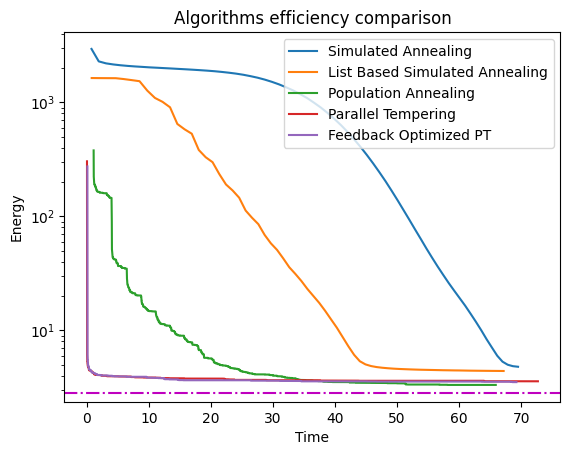

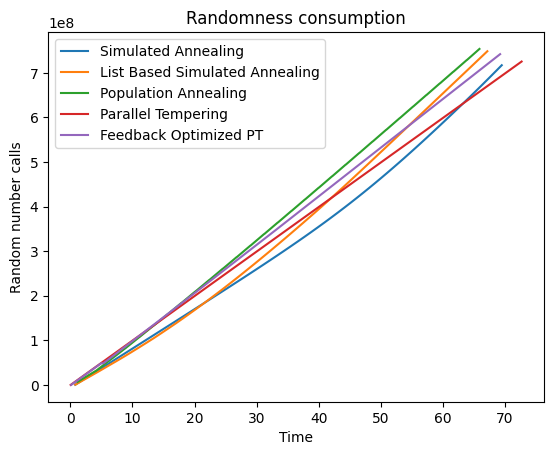

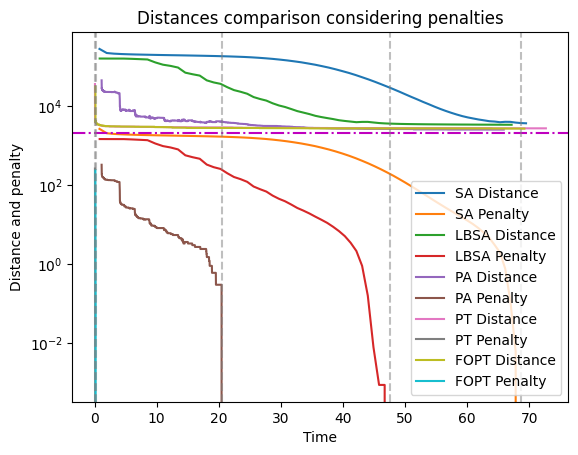

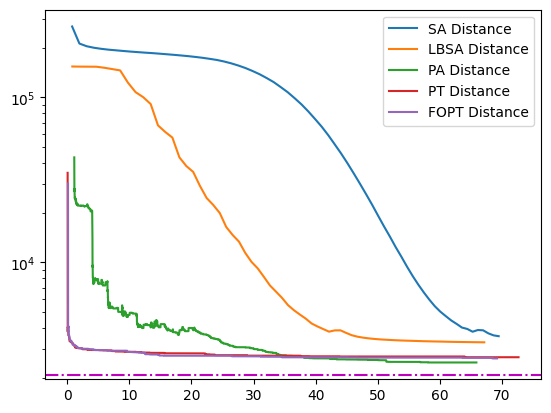

In [36]:

plt.style.use('default')
fig2, ax2=plt.subplots()
fig3, ax3=plt.subplots()
fig4, ax4=plt.subplots()
fig5, ax5=plt.subplots()

### SA

timesk_sa = timesk_sa[timesk_sa > 0]
energiestime_sa = energiestime_sa[:len(timesk_sa)]   
randomnessk_sa =randomnessk_sa[:len(timesk_sa)]
distances_sa = distances_sa[:len(timesk_sa)]   
penalty_sa =penalty_sa[:len(timesk_sa)]


ax4.set_xlabel('Time')
ax4.set_ylabel('Distance and penalty')
ax4.set_title('Distances comparison considering penalties')

ax2.semilogy(timesk_sa/10, energiestime_sa, label='Simulated Annealing')
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')
ax2.set_title('Algorithms efficiency comparison')

ax3.plot(timesk_sa/10, randomnessk_sa/10, label='Simulated Annealing')
ax3.set_xlabel('Time')
ax3.set_ylabel('Random number calls')
ax3.set_title('Randomness consumption')

ax4.semilogy(timesk_sa/10, distances_sa, label='SA Distance')
ax4.semilogy(timesk_sa/10, penalty_sa, label='SA Penalty')
ax5.semilogy(timesk_sa/10, distances_sa, label='SA Distance')

##LBSA

timesk_lbsa = timesk_lbsa[timesk_lbsa > 0]
energiestime_lbsa = energiestime_lbsa[:len(timesk_lbsa)] 
randomnessk_lbsa =randomnessk_lbsa[:len(timesk_lbsa)]
distances_lbsa =distances_lbsa[:len(timesk_lbsa)]
penalty_lbsa =penalty_lbsa[:len(timesk_lbsa)]



ax2.semilogy(timesk_lbsa/10, energiestime_lbsa, label='List Based Simulated Annealing')
ax3.plot(timesk_lbsa/10, randomnessk_lbsa/10, label='List Based Simulated Annealing')
ax4.semilogy(timesk_lbsa/10, distances_lbsa, label='LBSA Distance')
ax4.semilogy(timesk_lbsa/10, penalty_lbsa, label='LBSA Penalty')
ax5.semilogy(timesk_lbsa/10, distances_lbsa, label='LBSA Distance')

## PA

timesk_pa = timesk_pa[timesk_pa > 0]
energiestime_pa = energiestime_pa[:len(timesk_pa)]   
randomnessk_pa = randomnessk_pa[:len(timesk_pa)]   
distances_pa = distances_pa[:len(timesk_pa)]   
penalty_pa = penalty_pa[:len(timesk_pa)]   

ax2.semilogy(timesk_pa, energiestime_pa, label='Population Annealing')
ax3.plot(timesk_pa, randomnessk_pa, label='Population Annealing')
ax4.semilogy(timesk_pa, distances_pa, label='PA Distance')
ax4.semilogy(timesk_pa, penalty_pa, label='PA Penalty')
ax5.semilogy(timesk_pa, distances_pa, label='PA Distance')




## PT

timesk_pt = timesk_pt[timesk_pt > 0]
energiestime_pt = energiestime_pt[:len(timesk_pt)]
randomnessk_pt=randomnessk_pt[:len(timesk_pt)]
distances_pt=distances_pt[:len(timesk_pt)]
penalty_pt=penalty_pt[:len(timesk_pt)]


ax2.semilogy(timesk_pt, energiestime_pt, label='Parallel Tempering')
ax3.plot(timesk_pt, randomnessk_pt, label='Parallel Tempering')
ax4.semilogy(timesk_pt, distances_pt, label='PT Distance')
ax4.semilogy(timesk_pt, penalty_pt, label='PT Penalty')
ax5.semilogy(timesk_pt, distances_pt, label='PT Distance')



## FOPT

timesk_fopt = timesk_fopt[timesk_fopt > 0]
energiestime_fopt = energiestime_fopt[:len(timesk_fopt)]   
randomnessk_fopt=randomnessk_fopt[:len(timesk_fopt)]
distances_fopt=distances_fopt[:len(timesk_fopt)]
penalty_fopt=penalty_fopt[:len(timesk_fopt)]

ax2.semilogy(timesk_fopt, energiestime_fopt, label='Feedback Optimized PT')
ax3.plot(timesk_fopt, randomnessk_fopt, label='Feedback Optimized PT')
ax4.semilogy(timesk_fopt, distances_fopt, label='FOPT Distance')
ax4.semilogy(timesk_fopt, penalty_fopt, label='FOPT Penalty')
ax5.semilogy(timesk_fopt, distances_fopt, label='FOPT Distance')


### Vertical lines from which penalty is 0
index1=np.where(penalty_sa==0)[0][0]
index2=np.where(penalty_lbsa==0)[0][0]
index3=np.where(penalty_pa==0)[0][0]
index4=np.where(penalty_pt==0)[0][0]
index5=np.where(penalty_fopt==0)[0][0]


ax4.axvline(x=timesk_sa[index1]/10, color='gray', alpha=0.5, linestyle='--')
ax4.axvline(x=timesk_lbsa[index2]/10, color='gray', alpha=0.5, linestyle='--')
ax4.axvline(x=timesk_pa[index3], color='gray', alpha=0.5, linestyle='--')
ax4.axvline(x=timesk_pt[index4], color='gray', alpha=0.5, linestyle='--')
ax4.axvline(x=timesk_fopt[index5], color='gray', alpha=0.5, linestyle='--')


#Horizontal lines indicating optimal energies and distances
ax2.axhline(y=optimalenergy, color='m', linestyle='dashdot')
ax4.axhline(y=optimaldistance, color='m', linestyle='dashdot')
ax5.axhline(y=optimaldistance, color='m', linestyle='dashdot')


ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()


fig2.savefig('efficiency.png',bbox_inches='tight')
fig3.savefig('randomness.png',bbox_inches='tight')
fig4.savefig('distances.png',bbox_inches='tight')


Zoom of the energies and distances for this particular instance:

In [37]:
### Zooms
plt.style.use('default')

ax2.set_ylim([2.5,10])
ax4.set_ylim([2000,4500])


handles, labels = ax4.get_legend_handles_labels()
handles=np.delete(handles,[1,3,5,7,9])
labels=np.delete(labels,[1,3,5,7,9])

ax4.legend(handles, labels)
del ax4.lines[1]

fig2.savefig('efficiencyzoom.png',bbox_inches='tight')
fig4.savefig('distanceszoom.png',bbox_inches='tight')

/tmp/ipykernel_447251/2685481556.py:14: MatplotlibDeprecationWarning: 
The modification of the Axes.lines property was deprecated in Matplotlib 3.5 and will be removed two minor releases later. Use Artist.remove() instead.
  del ax4.lines[1]


Plots of the relevant figures of merit of the feedback procedure for FOPT:

0
1
2
3


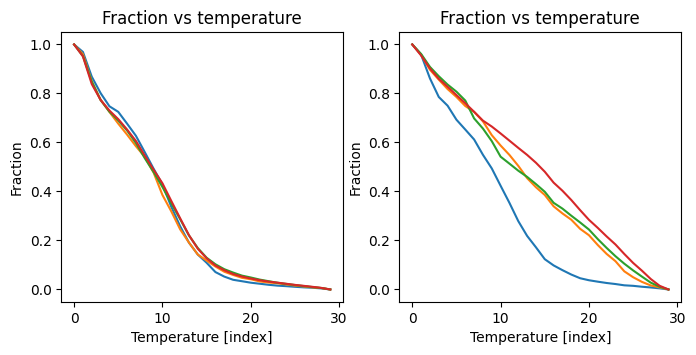

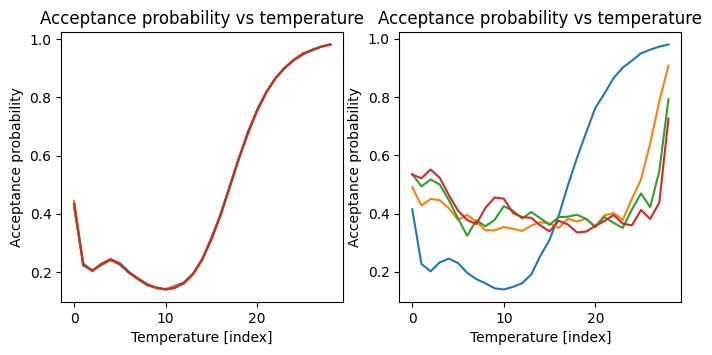

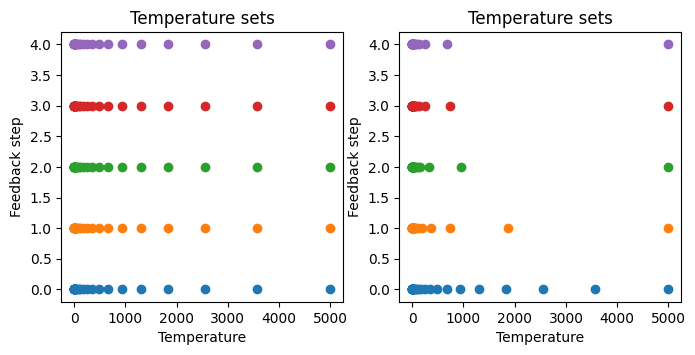

In [38]:

fig6,(ax6,ax62)=plt.subplots(1,2,figsize=(8,3.5))
fig7,(ax7,ax72)=plt.subplots(1,2,figsize=(8,3.5))
fig8,(ax8,ax82)=plt.subplots(1,2,figsize=(8,3.5))

ax6.set_xlabel('Temperature [index]')
ax6.set_ylabel('Fraction')
ax6.set_title('Fraction vs temperature')
ax62.set_xlabel('Temperature [index]')
ax62.set_ylabel('Fraction')
ax62.set_title('Fraction vs temperature')

ax7.set_xlabel('Temperature [index]')
ax7.set_ylabel('Acceptance probability')
ax7.set_title('Acceptance probability vs temperature')
ax72.set_xlabel('Temperature [index]')
ax72.set_ylabel('Acceptance probability')
ax72.set_title('Acceptance probability vs temperature')

ax8.set_xlabel('Temperature')
ax8.set_ylabel('Feedback step')
ax8.set_title('Temperature sets')
ax82.set_xlabel('Temperature')
ax82.set_ylabel('Feedback step')
ax82.set_title('Temperature sets')

### Fraction
for i in range(Nmainiter-1):
    ax6.plot(fractionk_meaniter[i][0],label='Parallel Tempering PT')

for i in range(Nmainiter-1):
    print(i)
    ax62.plot(fractionk_meaniter_fopt[i][0])
    
    
## Acceptance probabilities 
for i in range(Nmainiter-1):
    ax7.plot(accprobk_meaniter[i][0])
    
for i in range(Nmainiter-1):
    ax72.plot(accprobk_meaniter_fopt[i][0])    
    
    
    
## Temperatures   
for i in range(Nmainiter):
    aa=i*np.ones(30)
    ax8.plot(Temps_ink_meaniter[i][0],aa,'o')


for i in range(Nmainiter):
    aa=i*np.ones(30)
    ax82.plot(Temps_ink_meaniter_fopt[i][0],aa,'o')

    
    
fig6.savefig('fractions3.png',bbox_inches='tight')
fig7.savefig('acceptances3.png',bbox_inches='tight')
fig8.savefig('temperatures3.png',bbox_inches='tight')

We can also compare the geometric schedule used in SA with the one automatically generated by LBSA:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.75104532 0.74284311 0.72609693 0.72471105 0.71569861 0.71439444
 0.7097583  0.70073976 0.69124142 0.68535136 0.66842715 0.66794409
 0.66780485 0.66728636 0.65741607 0.65112593 0.64615424 0.63512806
 0.60002763 0.59615319 0.59401874 0.57956623 0.57928295 0.57922079
 0.55224686 0.5237056  0.52186988 0.51781063 0.51204434 0.50659476
 0.48910479 0.48816053 0.48500405 0.48193912 0.47527577 0.4742474
 0.46824197 0.4604514  0.4590484  0.4571387  0.44971379 0.44779253
 0.43349305 0.43307867 0.42848777 0.42703477 0.42505687 0.41793754
 0.41346123 0.41265587 0.40808957 0.39986077 0.39365561 0.39168366
 0.38361308 0.38361308 0.38361308 0.38361308 0.38361308 0.38361308
 0.38361308 0.38361308 0.38361308 0.38361308 0.38361308 0.38361308
 0.38361308 0.38361308 0.38361308 0.37686798 0.37686798 0.37686798
 0.37686798 0.37686798 0.36307089 0.36149838 0.36149838 0.3596176
 0.34012468 0.3284407  0.32428992 0.32296614 0.32296614 0.32296614
 0.32296614 0.32296614 0.32296614 0.32296614 0.32296614 0.322966

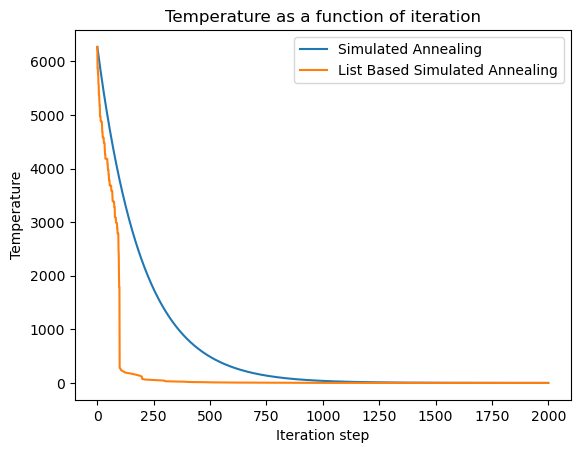

In [193]:
b=np.geomspace(list2[0], list2[-1],iterations)

plt.style.use('default')

fig, ax=plt.subplots()
ax.set_xlabel('Iteration step')
ax.set_ylabel('Temperature')
ax.set_title('Temperature as a function of iteration')


ax.plot(iterationsk,b,label='Simulated Annealing')
ax.plot(iterationsk,list2,label='List Based Simulated Annealing')
ax.legend()
fig.savefig('temperatureslists.eps',bbox_inches='tight')